# 🏞 Convolutional Neural Network

在本节中，我们将演示在 CIFAR 数据集上训练你自己的卷积神经网络（CNN）

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

## 0. Parameters <a name="parameters"></a>

In [2]:
NUM_CLASSES = 10
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.0005
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Prepare the Data <a name="prepare"></a>

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,255] -> [0,1]
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


100.0%


## 2. Build the model <a name="build"></a>

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(64, 64, 3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64*8*8, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)  # flatten
        x = F.leaky_relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(DEVICE)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 3. Train the model <a name="train"></a>

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch [{epoch}/{EPOCHS}] Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

Epoch [1/10] Loss: 1.3525, Acc: 0.5210
Epoch [2/10] Loss: 0.9796, Acc: 0.6601
Epoch [3/10] Loss: 0.8358, Acc: 0.7116
Epoch [4/10] Loss: 0.7409, Acc: 0.7442
Epoch [5/10] Loss: 0.6629, Acc: 0.7673
Epoch [6/10] Loss: 0.6068, Acc: 0.7889
Epoch [7/10] Loss: 0.5382, Acc: 0.8136
Epoch [8/10] Loss: 0.4930, Acc: 0.8272
Epoch [9/10] Loss: 0.4455, Acc: 0.8437
Epoch [10/10] Loss: 0.4077, Acc: 0.8566


## 4. Evaluation <a name="evaluate"></a>

In [6]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

Test Accuracy: 0.7707


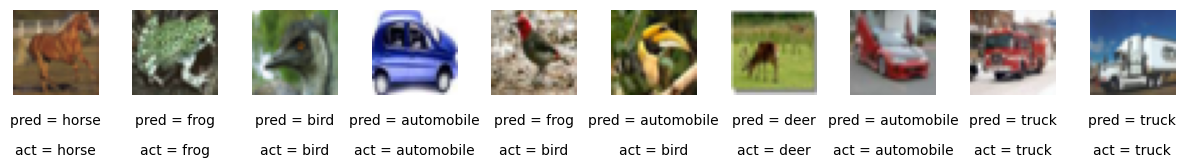

In [7]:
CLASSES = np.array([
    "airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"
])

n_to_show = 10
indices = random.sample(range(len(test_dataset)), n_to_show)

fig = plt.figure(figsize=(15,3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img, label = test_dataset[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis("off")
    pred_label = CLASSES[all_preds[idx]]
    true_label = CLASSES[label]
    ax.text(0.5, -0.35, f"pred = {pred_label}", fontsize=10, ha="center", transform=ax.transAxes)
    ax.text(0.5, -0.7, f"act = {true_label}", fontsize=10, ha="center", transform=ax.transAxes)
    ax.imshow(np.transpose(img.numpy(), (1,2,0)))